In [12]:
import sys
import numpy as np
import torch
import importlib 

from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.functional import F
import torch.nn as nn
import torch.distributions as dist

import matplotlib
import matplotlib.pyplot as plt

sys.path.append('../')
from utils_modules.models import Expander, vector_to_Cov
from utils_modules.vicreg import vicreg_loss
import utils_modules.data as utils_data
import utils_modules.baryons_toy_Pk as utils_toy_Pk


In [13]:
# select device; use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device: %s'%(device))

Device: cuda


In [14]:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 10}
matplotlib.rc('font', **font)

rcnew = {"mathtext.fontset" : "cm", 
         "text.usetex": False,
         
         'figure.frameon': True,
         'axes.linewidth': 2.,
         
         "axes.titlesize" : 32, 
         "axes.labelsize" : 36,
         "legend.fontsize" : 34,
         'legend.fancybox': True,
         'lines.linewidth': 2.5,
         
         'xtick.alignment': 'center',
          'xtick.bottom': True,
          'xtick.color': 'black',
          'xtick.direction': 'in',
          'xtick.labelbottom': True,
          'xtick.labelsize': 30, #17.5,
          'xtick.labeltop': False,
          'xtick.major.bottom': True,
          'xtick.major.pad': 6.0,
          'xtick.major.size': 14.0,
          'xtick.major.top': True,
          'xtick.major.width': 1.5,
          'xtick.minor.bottom': True,
          'xtick.minor.pad': 3.4,
          'xtick.minor.size': 7.0,
          'xtick.minor.top': True,
          'xtick.minor.visible': True,
          'xtick.minor.width': 1.0,
          'xtick.top': True,
         
          'ytick.alignment': 'center_baseline',
          'ytick.color': 'black',
          'ytick.direction': 'in',
          'ytick.labelleft': True,
          'ytick.labelright': False,
          'ytick.labelsize': 30, #17.5,
          'ytick.left': True,
          'ytick.major.left': True,
          'ytick.major.pad': 6.0,
          'ytick.major.right': True,
          'ytick.major.size': 14.0,
          'ytick.major.width': 1.5,
          'ytick.minor.left': True,
          'ytick.minor.pad': 3.4,
          'ytick.minor.right': True,
          'ytick.minor.size': 7.0,
          'ytick.minor.visible': True,
          'ytick.minor.width': 1.0,
          'ytick.right': True
         
        }


plt.rcParams.update(rcnew)
plt.style.use('tableau-colorblind10')
%config InlineBackend.figure_format = 'retina'


## Generate parameters and Pks

In [15]:
kmin  = 7e-3 #h/Mpc
kmax = 1

kF     = kmin
k_bins = int((kmax-kmin)/kF)
k      = np.arange(3,k_bins+2)*kF 
Nk     = 4.0*np.pi*k**2*kF/kF**3  #number of modes in each k-bin

# model parameters
predict_D     = True
Pk_continuous = True #whether fix A_value for kpivot or not

dset_size = 1000
train_frac, valid_frac, test_frac = 0.8, 0.1, 0.1

seed = 1
splits = 10

In [16]:
params = utils_toy_Pk.generate_params(dset_size, splits, 
                                                   predict_D = predict_D, 
                                                   Pk_continuous = Pk_continuous,
                                                   seed=seed)
params = params.reshape(dset_size, splits, -1)
Pk = utils_toy_Pk.get_Pk_arr(k, Nk, params, predict_D = predict_D, seed=seed)

#########
dset = TensorDataset(torch.tensor(np.log(Pk)), torch.tensor(params))
num_params = 4
batch_size= 256
train_dset, valid_dset, test_dset = torch.utils.data.random_split(dset,
                                                                [int(train_frac*dset_size),
                                                                 int(valid_frac*dset_size), 
                                                                 int(test_frac*dset_size)],
                                                                 generator=torch.Generator().manual_seed(seed))

test_dset = TensorDataset(dset.tensors[0][test_dset.indices].reshape(-1, len(k)),
                          dset.tensors[1][test_dset.indices].reshape(-1, num_params))
test_loader  = DataLoader(test_dset, batch_size, shuffle = False)

## Load the models

In [17]:
inv, var, cov = 15, 15, 1
fmodel = 'trained_models/VICReg_{:d}_{:d}_{:d}.pt'.format(inv, var, cov)
fout   = 'trained_models/VICReg_{:d}_{:d}_{:d}.txt'.format(inv, var, cov)
    
# define the expander model
hidden = 16
last_layer = 32
args_net = [hidden, 
            last_layer, last_layer, last_layer, 
            last_layer, last_layer, last_layer]
net = Expander(args_net, k.shape[0], bn = True).to(device)
net.load_state_dict(torch.load(fmodel))
net.eval();


In [18]:
# inference network
n_params = 3
n_tril = int(n_params * (n_params + 1) / 2)  # Number of parameters in lower triangular matrix, for symmetric matrix
n_out = n_params + n_tril  # Dummy output of neural network

# architecture parameters
last_layer = 32
mlp_lr_units = [4*last_layer, 4*last_layer, n_out]
lr_net = Expander(mlp_lr_units, last_layer, bn = True).to(device)

fmodel_lr = fmodel[:-3] + '_inference_network.pt'
fout_lr   = fout[:-4] + '_inference_network.txt'


lr_net.load_state_dict(torch.load(fmodel_lr))
lr_net.eval(); 


## Results on the test set

In [20]:
test_loss, num_points = 0., 0
params_true = []
params_pred = []
errors_pred = []
with torch.no_grad(): 
    for x, y in test_loader:
        x = x.float().to(device)
        y = y.to(device)[:, [0, 1, 3]]
        y_NN = lr_net(net(x))
        
        y_pred, cov_pred = y_NN[:, :n_params], y_NN[:, n_params:]
        Cov = vector_to_Cov(cov_pred.cpu()).to(device=device)
        loss = -dist.MultivariateNormal(loc=y, covariance_matrix=Cov).log_prob(y_pred).mean()
        
        test_loss += (loss.cpu().item())*x.shape[0]
        num_points += x.shape[0]
        
        params_true.append(y)
        params_pred.append(y_pred)
        errors_pred.append(Cov)
    
    test_loss = test_loss/num_points
print(test_loss)
params_true = torch.cat(params_true)
params_pred = torch.cat(params_pred)
errors_pred = torch.cat(errors_pred)

MSE_error = F.mse_loss(params_true[:, :2], params_pred[:, :2]).cpu().numpy()
print('MSE error: {:}'.format(MSE_error))
MSE_error = F.mse_loss(params_true[:, :1], params_pred[:, :1]).cpu().numpy()
print('MSE error on OmegaM: {:}'.format(MSE_error))
MSE_error = F.mse_loss(params_true[:, 1:2], params_pred[:, 1:2]).cpu().numpy()
print('MSE error on sigma8: {:}'.format(MSE_error))

print('\nActual errors on A, B (relative, %)')
print((torch.abs(params_pred[:, :1] - params_true[:, :1])/params_true[:, :1]).mean()*100)
print(-(torch.abs(params_pred[:, 1:2] - params_true[:, 1:2])/params_true[:, 1:2]).mean()*100)

print('\nPredicted errors on A, B (relative, %)')
print((torch.sqrt(errors_pred[:, 0, 0])/params_pred[:, :1]).mean()*100)
print(-(torch.sqrt(errors_pred[:, 1, 1])/params_pred[:, 1:2]).mean()*100)


-5.397384708404541
MSE error: 0.00016736195969310234
MSE error on OmegaM: 0.00010875035857721993
MSE error on sigma8: 0.00022597356080898473

Actual errors on A, B (relative, %)
tensor(2.1524, device='cuda:0', dtype=torch.float64)
tensor(3.8707, device='cuda:0', dtype=torch.float64)

Predicted errors on A, B (relative, %)
tensor(5.0369, device='cuda:0')
tensor(11.8966, device='cuda:0')


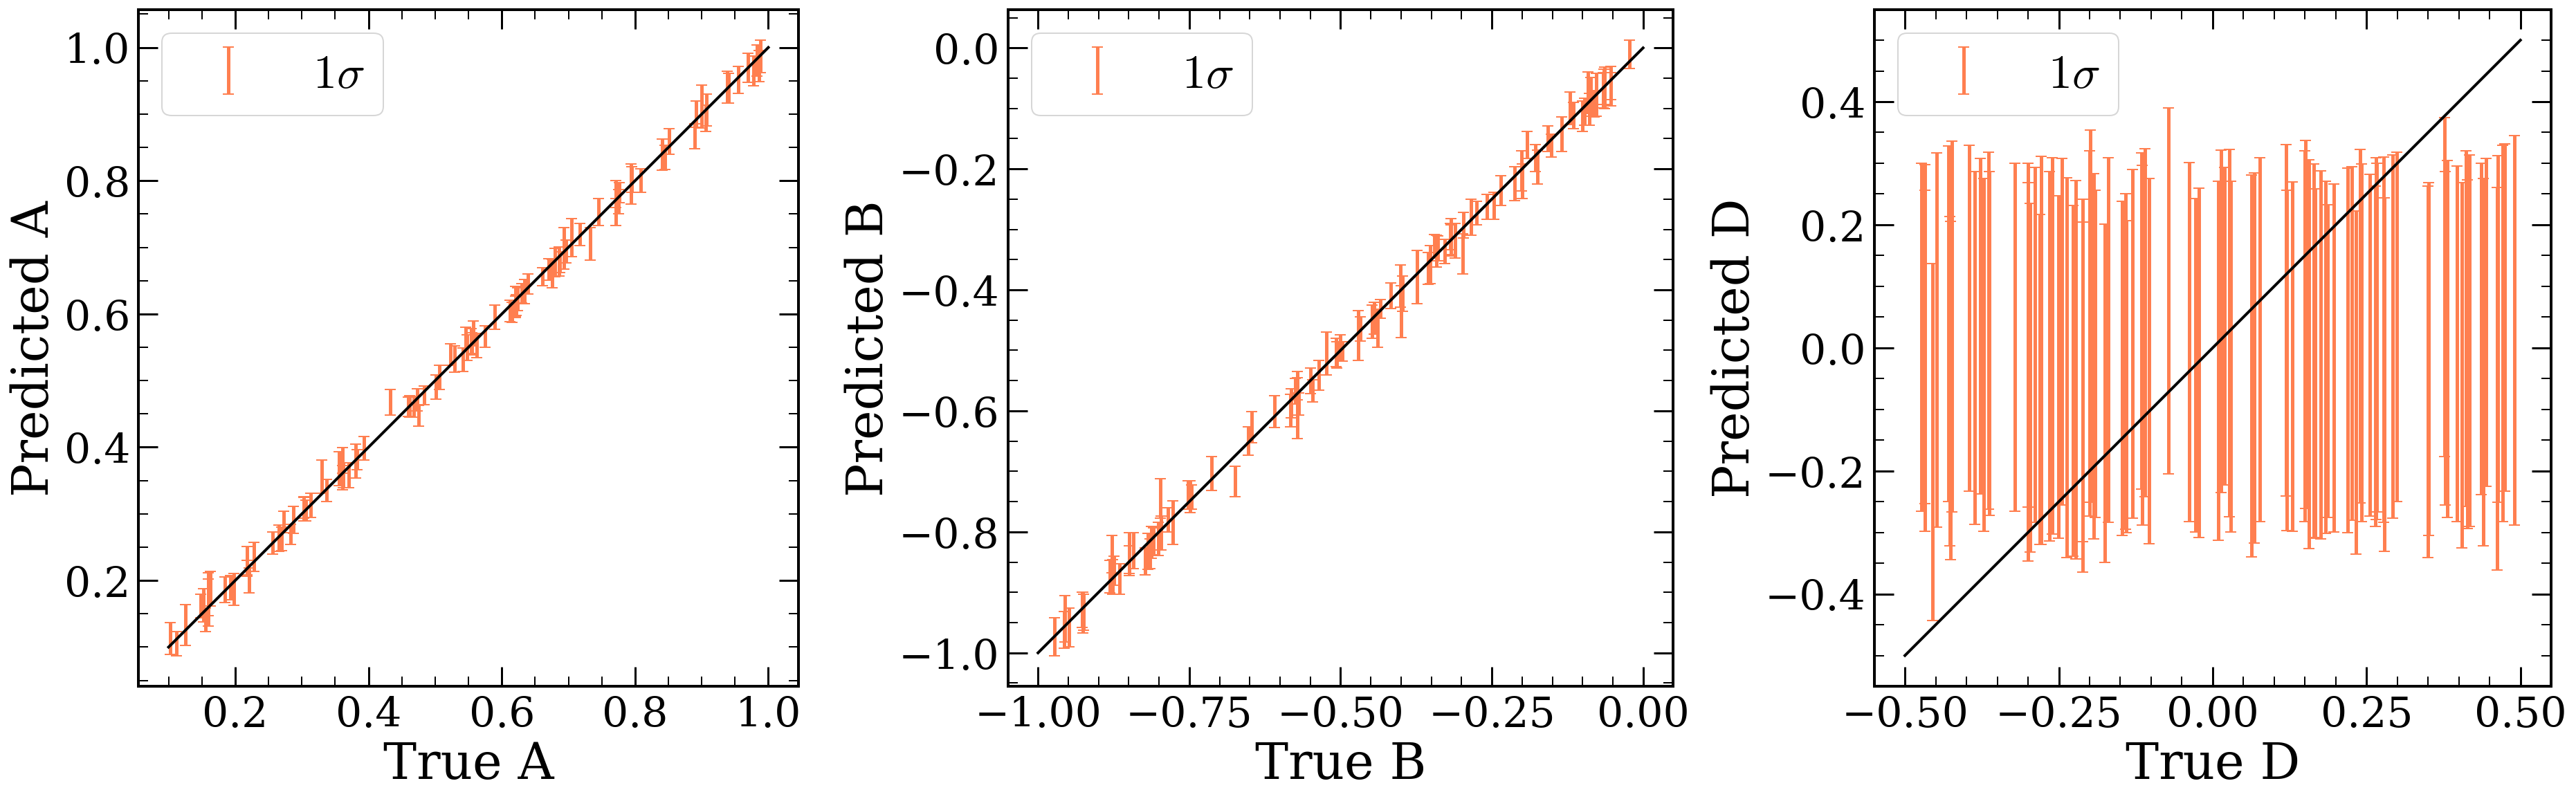

In [21]:
uniq_vals, uniq_indices = np.unique(params_true[:, 0].cpu(), return_index=True)
fig, axs = plt.subplots(1, 3, figsize=(32, 9))

axs[0].set_ylabel('Predicted A')
axs[0].set_xlabel('True A')
axs[0].errorbar(params_true[uniq_indices, 0].cpu(), params_pred[uniq_indices, 0].cpu(), 
                yerr=torch.sqrt(errors_pred[uniq_indices, 0, 0]).cpu(), 
                linestyle = '', capsize = 4, label = r'$1\sigma$', c = 'coral')
axs[0].plot([0.1, 1.], [0.1, 1.], c = 'k', lw = 2)
axs[0].legend(loc = 'upper left')
axs[0].set_aspect('equal')

axs[1].set_ylabel('Predicted B')
axs[1].set_xlabel('True B')
axs[1].errorbar(params_true[uniq_indices, 1].cpu(), params_pred[uniq_indices, 1].cpu(), 
                yerr=torch.sqrt(errors_pred[uniq_indices, 1, 1]).cpu(), 
                linestyle = '', capsize = 4, label = r'$1\sigma$', c = 'coral')
axs[1].plot([-1, 0.], [-1., 0.], c = 'k', lw = 2)
axs[1].legend(loc = 'upper left')
axs[1].set_aspect('equal')

axs[2].set_ylabel('Predicted D')
axs[2].set_xlabel('True D')
axs[2].errorbar(params_true[uniq_indices, 2].cpu(), params_pred[uniq_indices, 2].cpu(), 
                yerr=torch.sqrt(errors_pred[uniq_indices, 2, 2]).cpu(), 
                linestyle = '', capsize = 4, label = r'$1\sigma$', c = 'coral')
axs[2].plot([-.5, 0.5], [-.5, 0.5], c = 'k', lw = 2, )
axs[2].legend(loc = 'upper left')
axs[2].set_aspect('equal')